# Unscaled training set
Load the unscaled training set from file and get the training and validation split.

In [1]:
from tensorflow import keras
from tensorflow.keras import layers
import sys
sys.path.append("..")
from src.data import Dataset
from src.model import NeuralNetwork

In [2]:
d = Dataset(dataset_path="../data/processed/initial/train_unscaled.csv")
x_train, x_val, y_train, y_val = d.get_splits()

# Building the network
Create a network with 4 layers and train. The layer units are estimated folling the rule of thumb of 
$$\mathit{hidden\;neurons} = \frac{2}{3}\mathit{input} + \mathit{output} $$

In [3]:
net = NeuralNetwork.create_model(neurons=(132, 65, 33, 10),
                                 optimizer=keras.optimizers.RMSprop(), 
                                 loss=keras.losses.SparseCategoricalCrossentropy(), 
                                 metrics=["accuracy"])

65
33


In [4]:
history = net.fit(x_train, 
                  y_train, 
                  validation_data=(x_val, y_val),
                  batch_size=128, 
                  epochs=20, 
                  verbose=0);

In [5]:
net.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 132)               17556     
_________________________________________________________________
dense_1 (Dense)              (None, 65)                8645      
_________________________________________________________________
dense_2 (Dense)              (None, 33)                2178      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                340       
Total params: 28,719
Trainable params: 28,719
Non-trainable params: 0
_________________________________________________________________


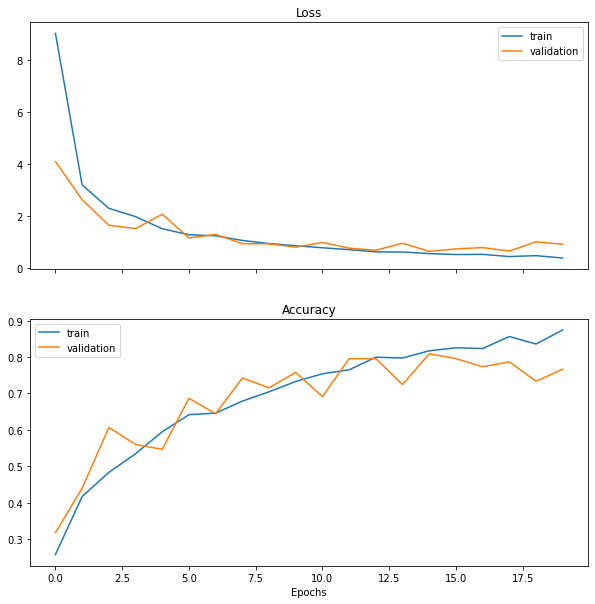

In [6]:
from matplotlib import pyplot as plt

def show_plots():
    fig, (ax1, ax2) = plt.subplots(2, sharex=True,figsize=(10,10))
    plt.xlabel("Epochs")
    ax1.set_title("Loss")

    ax1.plot(history.history['loss'], label='train')
    ax1.plot(history.history['val_loss'], label='validation')
    ax1.legend()

    ax2.set_title("Accuracy")
    ax2.plot(history.history['accuracy'], label='train')
    ax2.plot(history.history['val_accuracy'], label='validation')
    ax2.legend()
    
show_plots()

# Test folds performance
Test the performance on folds excluded from the training set, and then compute mean accuracy and standard deviation.

In [7]:
import numpy as np

def show_accuracy_loss(scaling):
    loss = []
    accuracy = []

    for fold in [5, 7, 8, 9, 10]:
        td = Dataset(dataset_path=f"../data/processed/initial/test_{fold}_{scaling}.csv", test_size=0)
        x_test, y_test = td.get_splits()
        results = net.evaluate(x_test, y_test, batch_size=128)
        loss.append(results[0])
        accuracy.append(results[1])

    print("\nAccuracy:")
    print(f"\tMean: {np.mean(accuracy)} \n\tStandard deviation: {np.std(accuracy)}")

    print("\nLoss:")
    print(f"\tMean: {np.mean(loss)} \n\tStandard deviation: {np.std(loss)}")
    
show_accuracy_loss(scaling="unscaled")

7/7 [==============================] - 0s 2ms/step - loss: 2.3759 - accuracy: 0.5090

Accuracy:
	Mean: 0.47803950905799864 
	Standard deviation: 0.038048542888559425

Loss:
	Mean: 2.9895168781280517 
	Standard deviation: 0.3489343730876412


# Scaled training and test folds
To see if scaling makes a difference, the next step is to load the scaled training and test sets and repeat the process.

In [8]:
d = Dataset(dataset_path="../data/processed/initial/train_scaled.csv")
x_train, x_val, y_train, y_val = d.get_splits()

In [10]:
history = net.fit(x_train,
                  y_train, 
                  validation_data=(x_val, y_val),
                  batch_size=128, 
                  epochs=20, 
                  verbose=0);

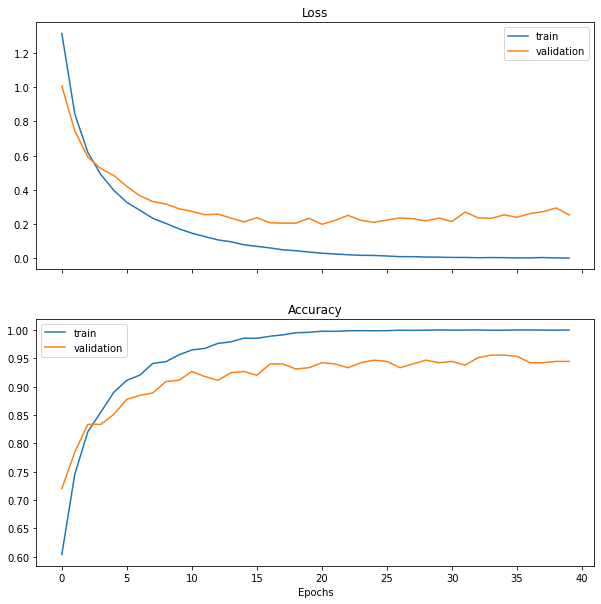

In [10]:
show_plots()

In [11]:
show_accuracy_loss(scaling="scaled")

7/7 [==============================] - 0s 2ms/step - loss: 3.0724 - accuracy: 0.6547

Accuracy:
	Mean: 0.6155625462532044 
	Standard deviation: 0.04975944398154962

Loss:
	Mean: 3.4631720542907716 
	Standard deviation: 0.8972167689920583


There's been a small improvement on accuracy, so from now on I'll apply scaling.
The next step is to apply PCA on the dataset, after extracting some more features.